In [30]:
import pandas as pd
import os
import s3fs # for reading from S3FileSystem
import json

%matplotlib inline
import matplotlib.pyplot as plt


import torch.nn as nn
import torch
import torch.utils.model_zoo as model_zoo
import numpy as np

import torchvision.models as models # To get ResNet18

# From - https://github.com/cfotache/pytorch_imageclassifier/blob/master/PyTorch_Image_Inference.ipynb
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from PIL import Image
from torch.autograd import Variable

from torch.utils.data.sampler import SubsetRandomSampler

# Prepare the Model

In [31]:
SAGEMAKER_PATH = r'/home/ec2-user/SageMaker'

MODEL_PATH = os.path.join(SAGEMAKER_PATH, r'sidewalk-cv-assets19/pytorch_pretrained/models/20e_slid_win_no_feats_r18.pt')

In [32]:
os.path.exists(MODEL_PATH)

True

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [34]:
# Use PyTorch's ResNet18
# https://stackoverflow.com/questions/53612835/size-mismatch-for-fc-bias-and-fc-weight-in-pytorch
model = models.resnet18(num_classes=5)  

In [35]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Prep Data

In [8]:
# From Galen

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# the dataset loads the files into pytorch vectors
#image_dataset = TwoFileFolder(dir_containing_crops, meta_to_tensor_version=2, transform=data_transform)

# the dataloader takes these vectors and batches them together for parallelization, increasing performance
#dataloader    = torch.utils.data.DataLoader(image_dataset, batch_size=4, shuffle=True, num_workers=4)

# this is the number of additional features provided by the dataset
#len_ex_feats = image_dataset.len_ex_feats
#dataset_size = len(image_dataset)

In [9]:
# Load in the data
data_dir = 'crops'

data = datasets.ImageFolder(data_dir, transform=test_transforms)
classes = data.classes
classes

['0_missing', '1_null', '2_obstacle', '3_present', '4_surface_prob']

In [10]:
!ls -a crops

.  ..  0_missing  1_null  2_obstacle  3_present  4_surface_prob


In [11]:
#!rm -f -r images/.ipynb_checkpoints/

In [12]:
# Examine the classes based on folders... 
# Need to make sure that we don't get a .ipynb_checkpoints as a folder
# Discussion here - https://forums.fast.ai/t/how-to-remove-ipynb-checkpoint/8532/19
classes

['0_missing', '1_null', '2_obstacle', '3_present', '4_surface_prob']

In [13]:
num = 30

indices = list(range(len(data)))
print(indices)
np.random.shuffle(indices)
idx = indices[:num]

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

#sampler = SubsetRandomSampler(idx)
loader = torch.utils.data.DataLoader(data, batch_size=num)
dataiter = iter(loader)
images, labels = dataiter.next()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [14]:
len(images)

22

In [15]:
# Look at the first image
images[0]

tensor([[[-1.7069, -1.7412, -1.7583,  ...,  0.0398,  0.1426,  0.3994],
         [-1.7412, -1.7583, -1.7754,  ..., -0.0458,  0.1254,  0.3823],
         [-1.7412, -1.7583, -1.7754,  ..., -0.1657,  0.0741,  0.3994],
         ...,
         [ 0.8104,  0.7591,  0.7077,  ...,  0.6049,  0.5878,  0.5707],
         [ 0.6906,  0.6392,  0.6049,  ...,  0.5707,  0.5707,  0.5364],
         [ 0.5707,  0.5364,  0.5193,  ...,  0.4851,  0.4851,  0.4851]],

        [[-1.5630, -1.5980, -1.6155,  ...,  0.0301,  0.1352,  0.3803],
         [-1.5980, -1.6155, -1.6331,  ..., -0.0574,  0.1176,  0.3627],
         [-1.5980, -1.6155, -1.6331,  ..., -0.1800,  0.0651,  0.3978],
         ...,
         [ 0.8179,  0.7654,  0.7129,  ...,  0.5378,  0.5203,  0.5028],
         [ 0.6954,  0.6429,  0.6078,  ...,  0.5203,  0.5028,  0.4853],
         [ 0.5903,  0.5553,  0.5378,  ...,  0.4503,  0.4328,  0.4503]],

        [[-1.4733, -1.4907, -1.5081,  ..., -0.0790,  0.0256,  0.2871],
         [-1.5081, -1.5256, -1.5256,  ..., -0

In [16]:
len(labels)

22

In [17]:
labels

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4])

In [40]:
# Note on how to make sure the model and the input tensors are both on cuda device (gpu)
# https://discuss.pytorch.org/t/runtimeerror-input-type-torch-cuda-floattensor-and-weight-type-torch-floattensor-should-be-the-same/21782/6

In [18]:
def predict_image(image, model):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index, output  

In [23]:
int(np.ceil(len(images) / 5))

5

*************0************
actual class: 0_missing
predicted class: 1_null
output: tensor([[-1.3227,  4.9604,  0.5491, -1.0336, -3.3085]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Result: False
*************1************
actual class: 0_missing
predicted class: 1_null
output: tensor([[-1.0689,  5.0198, -2.0848,  0.6828, -2.7331]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Result: False
*************2************
actual class: 0_missing
predicted class: 1_null
output: tensor([[-1.7641,  6.1712, -2.0229, -1.1096, -1.6082]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Result: False
*************3************
actual class: 0_missing
predicted class: 1_null
output: tensor([[ 0.1227,  4.5093, -3.6574,  2.5368, -3.4724]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Result: False
*************4************
actual class: 0_missing
predicted class: 1_null
output: tensor([[-0.7428,  6.4917, -3.2734,  0.6698, -3.3447]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Resu

<Figure size 432x288 with 0 Axes>

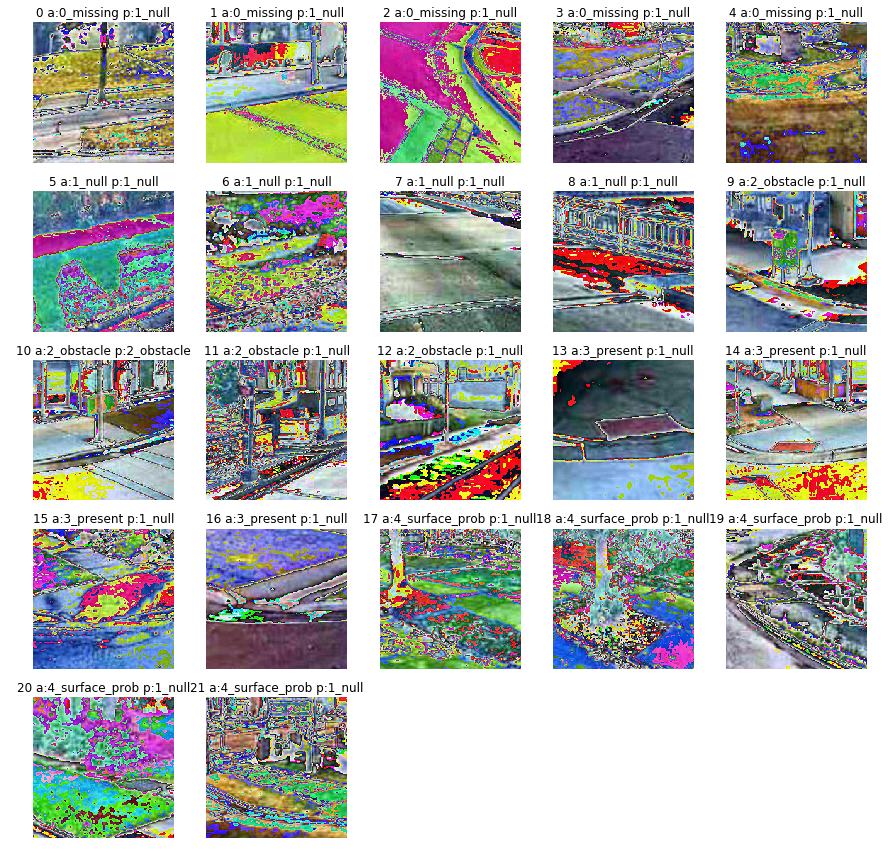

In [29]:
plt.cla()
plt.clf()

to_pil = transforms.ToPILImage()
#images, labels = get_random_images(5)
fig=plt.figure(figsize=(15,15))
short_images = images
num_rows = 5
num_cols = int(np.ceil(len(images) / num_rows))
for ii in range(len(short_images)):
    image = to_pil(images[ii])
    index, output = predict_image(image, model)
    print(f'*************{ii}************')
    actual_class = str(classes[int(labels[ii])])
    pred_class = str(classes[index])
    print(f'actual class: {actual_class}')
    print(f'predicted class: {pred_class}')
    print(f'output: {output}')
    sub = fig.add_subplot(num_rows, num_cols, ii+1)
    res = int(labels[ii]) == index
    print(f'Result: {res}')
    sub.set_title(f'{ii} a:{actual_class} p:{pred_class}')
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [109]:
res

False

# Comments and Questions

What's the order of the labels (and how I should order the folders for the input data?) 

This file implies that there are different orders
https://github.com/ProjectSidewalk/sidewalk-cv-assets19/blob/master/GSVutils/sliding_window.py

```label_from_int = ('Curb Cut', 'Missing Cut', 'Obstruction', 'Sfc Problem')
pytorch_label_from_int = ('Missing Cut', "Null", 'Obstruction', "Curb Cut", "Sfc Problem")```